# Hamiltonian Neural Network

### Importing Libraries

In [0]:
!pip install tensorflow==2.0.0-beta

In [0]:
import os
import io
import gym
import cv2
import pickle
import zipfile
import autograd
import scipy.misc
import imageio, shutil
import scipy.integrate
solve_ivp  = scipy.integrate.solve_ivp
from IPython import display
import autograd.numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from PIL import Image, ImageDraw, ImageSequence, ImageFont

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation

### Defining Parameters

In [0]:
TRAINING_DATA_LOCATION = "pendulum-pixels-dataset.pkl"
TESTING_DATA_LOCATION = "test_data.pickle"
LEARNING_RATE = 1e-4       # learning rate for training models
EPOCHS = 2000               # number of epochs to train models on

In [0]:
def make_gif(frames, save_dir, name='pendulum', duration=1e-1, pixels=None, divider=0):
    '''Given a three dimensional array [frames, height, width], make
    a gif and save it.'''
    temp_dir = './_temp'
    os.mkdir(temp_dir) if not os.path.exists(temp_dir) else None
    for i in range(len(frames)):
        im = (frames[i].clip(-.5,.5) + .5)*255
        im[divider,:] = 0
        im[divider + 1,:] = 255
        if pixels is not None:
          im = cv2.resize(im, dsize=pixels, interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(temp_dir + '/f_{:04d}.png'.format(i), im)

    images = []
    for file_name in sorted(os.listdir(temp_dir)):
        if file_name.endswith('.png'):
            file_path = os.path.join(temp_dir, file_name)
            images.append(imageio.imread(file_path))
    save_path = '{}/{}.gif'.format(save_dir, name)
    png_save_path = '{}.png'.format(save_path)
    imageio.mimsave(save_path, images, duration=duration)
    os.rename(save_path, png_save_path)

    shutil.rmtree(temp_dir) # remove all the images
    return png_save_path

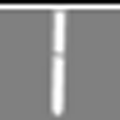

In [0]:
pickle_in = open(TRAINING_DATA_LOCATION,"rb")
data = pickle.load(pickle_in)
side = data['meta']['side']
trials = data['meta']['trials']
timesteps = data['meta']['timesteps']

frames = data['pixels'][:,:side**2].reshape(-1, side, side)[:400]
name = '{}-dataset'.format('pixels')
gifname = make_gif(frames, '', name=name, duration=1e-1, pixels=(120,120))

display.Image(filename=gifname, width=200)

In [0]:
class MLP(keras.Model):
    def __init__(self, input_dim=2):
        super(MLP, self).__init__()
        self.d1 = tf.keras.layers.Dense(200, activation='tanh')
        self.d2 = tf.keras.layers.Dense(200, activation='tanh')
        self.d3 = tf.keras.layers.Dense(input_dim, activation='linear')

    def forward(self, x):
        y = self.d1(x)
        y = self.d2(y)
        return self.d3(y)


class HNN(keras.Model):
  def __init__(self, input_dim=2):
    super(HNN, self).__init__()
    self.d1 = tf.keras.layers.Dense(200, activation='tanh')
    self.d2 = tf.keras.layers.Dense(200, activation='tanh')
    self.d3 = tf.keras.layers.Dense(1)
    M = np.eye(input_dim)
    M = np.concatenate((M[input_dim//2:], -M[:input_dim//2]), axis=0)
    self.M = tf.constant(M, dtype='double')

  def call(self, x):
    y = self.d1(x)
    y = self.d2(y)
    y = self.d3(y)
    return y

  def forward(self, x):
    with tf.GradientTape() as tape:
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
    y = tape.gradient(y, x)
    y = y @ self.M
    return y


class MLPEncoder(keras.Model):
    def __init__(self, input_dim=2):
        super(MLPEncoder, self).__init__()
        self.d1 = tf.keras.layers.Dense(200, activation='tanh')
        self.d2 = tf.keras.layers.Dense(200, activation='tanh')
        self.d3 = tf.keras.layers.Dense(200, activation='tanh')
        self.d4 = tf.keras.layers.Dense(2)
        
        self.d5 = tf.keras.layers.Dense(200, activation='tanh')
        self.d6 = tf.keras.layers.Dense(200, activation='tanh')
        self.d7 = tf.keras.layers.Dense(200, activation='tanh')
        self.d8 = tf.keras.layers.Dense(input_dim)


    def encode(self, x):
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
        return self.d4(y)

    def decode(self, x):
        y = self.d5(x)
        y = self.d6(y)
        y = self.d7(y)
        return self.d8(y)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat


class PixelHNN(keras.Model):
    def __init__(self, input_dim, baseline=False):
        super(PixelHNN, self).__init__()
        self.autoencoder = MLPEncoder(input_dim=input_dim)
        self.baseline = baseline

        if (baseline):
            self.model = MLP(2)
        else:
            self.model = HNN(2)

    def encode(self, x):
        return self.autoencoder.encode(x)

    def decode(self, z):
        return self.autoencoder.decode(z)

    def time_derivative(self, z):
        return self.model.forward(z)

    def forward(self, x):
        z = self.encode(x)
        z_next = z + self.time_derivative(z)
        return self.decode(z_next)

In [0]:
def pixelhnn_loss(x, x_next, model, return_scalar=True):
    # encode pixel space -> latent dimension
    z = model.encode(x)
    z_next = model.encode(x_next)

    # autoencoder loss
    x_hat = model.decode(z)
    ae_loss = tf.reduce_mean(((x - x_hat)**2), 1)

    # hnn vector field loss
    z_hat_next = z + model.time_derivative(tf.Variable(z)) # replace with rk4
    hnn_loss = tf.reduce_mean(((z_next - z_hat_next)**2), 1)

    # canonical coordinate loss
    # -> makes latent space look like (x, v) coordinates
    # print (z, z_next)
    w = z@[[1], [0]]
    dw = z@[[0], [1]]
    w_next = z_next@[[1], [0]]
    cc_loss = tf.reduce_mean(((dw-(w_next - w))**2), 1)

    # sum losses and take a gradient step
    loss = ae_loss + cc_loss + 1e-1 * hnn_loss
    # loss = hnn_loss
    if return_scalar:
        return tf.reduce_mean(loss)
    return loss


def train_pixelHNN(data, model=None, optimizer=None, learning_rate = 1e-3, epochs = 200, baseline=False):
    # loss_object = tf.keras.losses.MeanSquaredError()
    if (model is None):
        model = PixelHNN(input_dim=data['pixels'].shape[1], baseline=baseline)
    if (optimizer is None):
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(epochs):
        total = 0
        for j in range(len(data['pixels'])//200):
            with tf.GradientTape() as tape1:
                tape1.watch(model.trainable_variables)
                loss = pixelhnn_loss(tf.Variable(tf.stack(data['pixels'][j*200:(j+1)*200])), tf.Variable(tf.stack(data['next_pixels'][j*200:(j+1)*200])), model)
            gradients = tape1.gradient(loss, model.trainable_variables)
            # print (gradients)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            total += loss

        print (i, total/80)
    return model, optimizer

In [0]:
hnn_model, optimizer = train_pixelHNN(data, learning_rate=LEARNING_RATE, epochs=EPOCHS)

In [0]:
base_model, optimizer = train_pixelHNN(data, learning_rate=LEARNING_RATE, epochs=EPOCHS, baseline=True)

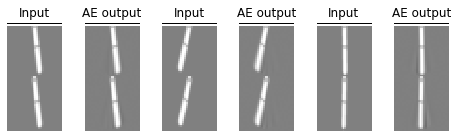

In [0]:
rows, cols = 1, 3
fig = plt.figure(figsize=[1.1*2*cols, 2*rows])

x = data['pixels']
x_next = data['next_pixels']

temp = np.random.randint(0, 16000, 6)
bx, bx_next = tf.Variable(tf.stack([x[temp[0]], x[temp[1]], x[temp[2]], x[temp[3]], x[temp[4]], x[temp[5]]])), tf.Variable(tf.stack([x_next[temp[0]], x_next[temp[1]], x_next[temp[2]], x_next[temp[3]], x_next[temp[4]], x_next[temp[5]]]))
bx_hat_next = hnn_model.autoencoder.forward(bx_next)

for r in range(rows):
  for c in range(cols):
    ix = r*2*cols + 2*c
    
    plt.subplot(rows, 2*cols, ix + 1)
    im = np.array(bx_next[ix]).reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("Input")
    
    
    plt.subplot(rows, 2*cols, ix + 2)
    im = np.array(bx_hat_next[ix]).reshape(-1,side)
    im = (im.clip(-.5,.5) + .5)
    im[0,:] = 0 ; im[1,:] = 1
    plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("AE output")
    
plt.tight_layout() ; plt.show()

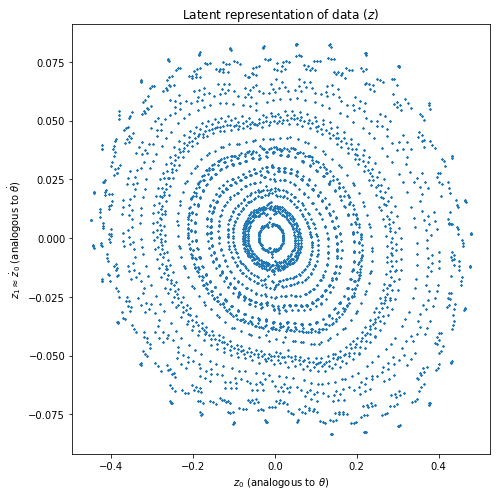

In [0]:
k = 3000
fig = plt.figure(figsize=(7, 7), facecolor='white')
ax = fig.add_subplot(1, 1, 1, frameon=True)
latents = np.array(hnn_model.encode(x))
plt.plot(latents[:k,0], latents[:k,1], '*', markersize=2)

ax.set_xlabel("$z_0$ (analogous to $\\theta$)")
ax.set_ylabel("$z_1 \\approx \dot z_0$ (analogous to $\dot \\theta$)")
plt.title("Latent representation of data ($z$)")

plt.tight_layout() ; plt.show()

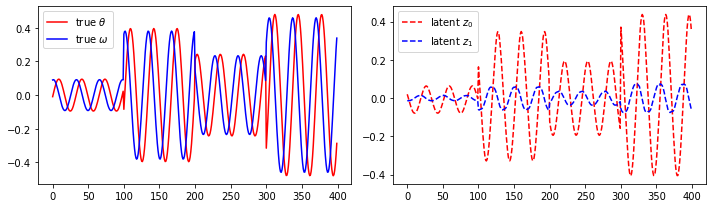

In [0]:
k = 400
fig = plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.plot(data['coords'][:k,0], "r-", label='true $\\theta$')    # ground truth coordinates (theta and omega)
plt.plot(data['coords'][:k,1], "b-", label='true $\omega$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(latents[:k,0], "r--", label='latent $z_0$')   # learned by autoencoder (in an unsupervised manner)
plt.plot(latents[:k,1], "b--", label='latent $z_1$')
plt.legend()

plt.tight_layout() ; plt.show()

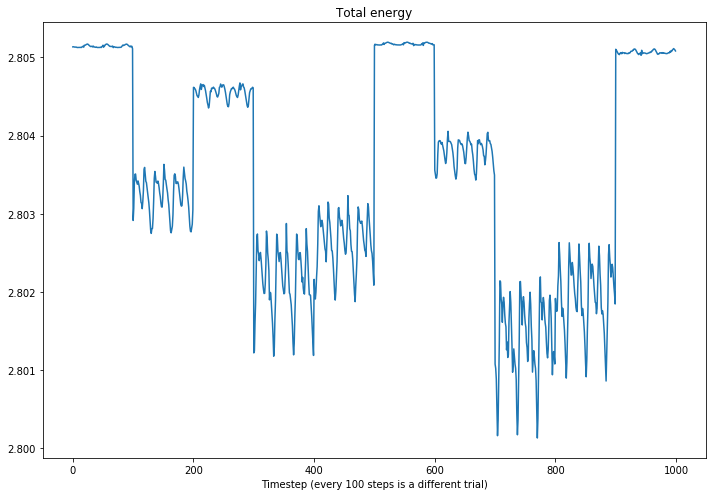

In [0]:
k = 1000
fig = plt.figure(figsize=[10,7])

z_values = hnn_model.encode(x[:k])
F1 = hnn_model.model.call(z_values)
energy = F1
plt.plot(energy)
plt.title("Total energy")
plt.xlabel("Timestep (every {} steps is a different trial)".format(timesteps))
plt.tight_layout() ; plt.show()

In [0]:
def integrate_model(model, t_span, y0, fun=None, **kwargs):
  def default_fun(t, np_x):
      x = np_x
      x = x.reshape((1, np.size(np_x))) # batch size of 1
      x = tf.Variable(x)
      dx = np.array(model.time_derivative(x)).reshape(-1)
      return dx
  fun = default_fun if fun is None else fun
  return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

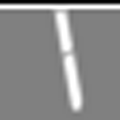

In [0]:
num_frames = 200
pickle_in = open(TESTING_DATA_LOCATION,"rb")
test_data = pickle.load(pickle_in)
side = test_data['meta']['side']

real_pixel_traj = test_data['pixels'][:,:side**2].reshape(-1, side, side)[:num_frames]
name = '{}-truth'.format('pixels')
gifname = make_gif(real_pixel_traj, '', name=name, duration=1e-1, pixels=(120,120))

display.Image(filename=gifname, width=200)

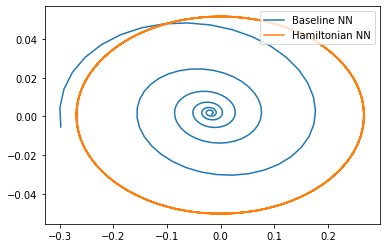

In [0]:
x0 = tf.Variable(test_data['pixels'][0:1])
base_y0 = np.array(base_model.encode(x0)).squeeze()
hnn_y0 = np.array(hnn_model.encode(x0)).squeeze()

# integrator settings
t_span = [0, 0.98*num_frames]
point_density = num_frames / t_span[-1]
t_eval = np.linspace(t_span[0], t_span[1], num_frames)

# integrate models
# Here we don't compute t_eval[0] because it's the initial state of the system
#   and thus is already known.
base_traj = integrate_model(base_model, t_span, base_y0, t_eval=t_eval[1:])
hnn_traj = integrate_model(hnn_model, t_span, hnn_y0, t_eval=t_eval[1:])

plt.plot(base_traj['y'][0], base_traj['y'][1], label='Baseline NN')
plt.plot(hnn_traj['y'][0], hnn_traj['y'][1], label='Hamiltonian NN')
plt.legend(loc='upper right')
plt.show()

In [0]:
base_zs = tf.Variable(base_traj['y'].T)
hnn_zs = tf.Variable(hnn_traj['y'].T)

base_pixel_traj = np.array(base_model.decode(base_zs))
hnn_pixel_traj = np.array(hnn_model.decode(hnn_zs))

_base_pixel_traj = base_pixel_traj[:,:side**2].reshape(-1, side, side)
_hnn_pixel_traj = hnn_pixel_traj[:,:side**2].reshape(-1, side, side)

# set initial values
x0 = real_pixel_traj[0:1]
_hnn_pixel_traj = np.concatenate([x0, _hnn_pixel_traj],axis=0)
_base_pixel_traj = np.concatenate([x0, _base_pixel_traj],axis=0)

trajs = np.concatenate([real_pixel_traj,
                        _base_pixel_traj,
                        _hnn_pixel_traj], axis=-1)

In [0]:
def hnn_conserve_energy(t, np_x):
    x = np_x
    x = x.reshape((1, np.size(np_x)))
    x = tf.Variable(x)
    dx = np.array(hnn_model.time_derivative(x)).reshape(-1)
    return dx
    
def hnn_add_energy(t, np_x):
    x = np_x
    x = x.reshape((1, np.size(np_x)))
    x = tf.Variable(x)
    with tf.GradientTape() as tape:
        F1 = hnn_model.model.call(x)
    dx = tape.gradient(F1, x)[0]
    np_dx = np.array(dx).reshape(-1)
    return np_dx

In [0]:
def L2_loss(u, v):
  return tf.reduce_mean((u-v)**2, 1)

def hamiltonian_fn(coords):
  k = 1.9  # this coefficient must be fit to the data
  q, p = np.split(coords,2)
  H = k*(1-np.cos(q)) + p**2 # pendulum hamiltonian
  return H

def learn_z2canonical(pixels, coords, model, train_steps=4000):
    '''Learn mapping from z space to canonical coordinates'''
    cc = tf.Variable(coords)
    x = tf.Variable(pixels)
    z = model.encode(x)
    
    z2cc = tf.keras.layers.Dense(2) # linear layer that we're going to learn // could also use MLP(2,50,2)
    optim = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    for i in range(100):
        for j in range(40):
            with tf.GradientTape() as tape1:
                loss = L2_loss(z2cc(z[j*400:(j+1)*400]), cc[j*400:(j+1)*400])
            gradients = tape1.gradient(loss, z2cc.trainable_variables)
            optim.apply_gradients(zip(gradients, z2cc.trainable_variables))
        if (i%20 == 0):
            print("step {}, train_loss {:.4e}".format(i, loss[0]))
    return z2cc


def pix2cc(model, pixels, z2cc=None):
    if z2cc is None:
        z2cc = learn_z2canonical(data['pixels'], data['coords'], model)
    x = tf.Variable(pixels)
    z = hnn_model.encode(x)
    cc = np.array(z2cc(z))
    return cc

#### ESTIMATE CANONICAL COORDINATES
true_cc = test_data['coords']
print('Getting Baseline NN canonical coords')
base_cc = pix2cc(base_model, base_pixel_traj)
print('\nGetting Hamiltonian NN canonical coords')
hnn_cc = pix2cc(hnn_model, hnn_pixel_traj)

y0 = true_cc[0:1]
base_cc = np.concatenate([y0, base_cc], axis=0)
hnn_cc = np.concatenate([y0, hnn_cc], axis=0)

#### USE THEM TO ESTIMATE TOTAL ENERGY
true_e = np.stack([hamiltonian_fn(c) for c in true_cc])
base_e = np.stack([hamiltonian_fn(c) for c in base_cc])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_cc])

Getting Baseline NN canonical coords
step 0, train_loss 9.1798e-02
step 20, train_loss 3.6384e-02
step 40, train_loss 1.3671e-02
step 60, train_loss 4.4055e-03
step 80, train_loss 1.3810e-03

Getting Hamiltonian NN canonical coords
step 0, train_loss 1.0529e-01
step 20, train_loss 3.5204e-02
step 40, train_loss 8.4801e-03
step 60, train_loss 1.4983e-03
step 80, train_loss 3.3594e-04


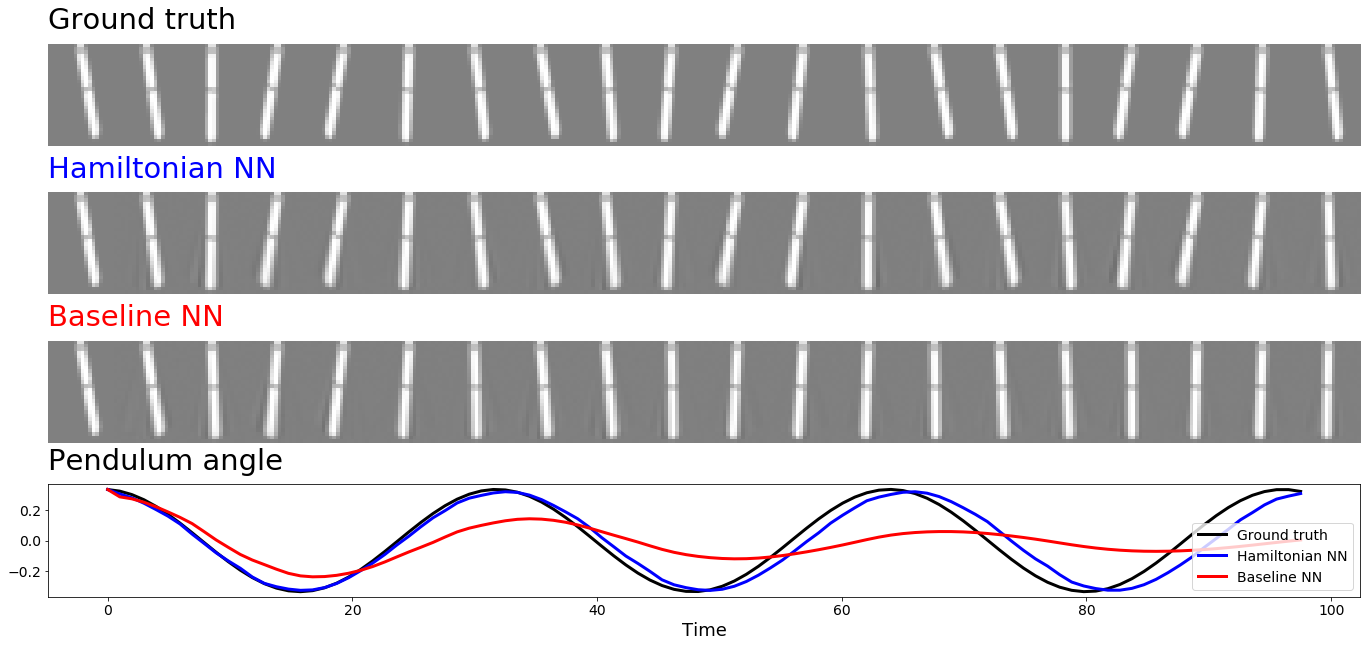

In [0]:
N = 18
tmax = 100
b = 5
k = tmax // N
true_seq = real_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
true_seq = (true_seq.clip(-.5,.5) + .5)*255

hnn_seq = _hnn_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
hnn_seq = (hnn_seq.clip(-.5,.5) + .5)*255

base_seq = _base_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
base_seq = (base_seq.clip(-.5,.5) + .5)*255

sy = 3
sx = .55*sy*(28.-2*b)/28

#### USE THEM TO ESTIMATE TOTAL ENERGY
true_e = np.stack([hamiltonian_fn(c) for c in true_cc])
base_e = np.stack([hamiltonian_fn(c) for c in base_cc])
hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_cc])

fs = 29 # font size
fig = plt.figure(figsize=[sx*N,3*sy],)

plt.subplot(4,1,1)
plt.imshow(true_seq, cmap='gray')
plt.title('Ground truth', fontsize=fs, pad=15, loc='left')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(hnn_seq, cmap='gray')
plt.title('Hamiltonian NN', fontsize=fs, pad=15, loc='left', color='b')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(4,1,3)
plt.imshow(base_seq, cmap='gray')
plt.title('Baseline NN', fontsize=fs, pad=15, loc='left', color='r')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(4,1,4)
plt.title('Pendulum angle', fontsize=fs, pad=15, loc='left')

plt.plot(t_eval[:tmax], true_cc[:tmax,0], 'k-', label='Ground truth', linewidth=3)
plt.plot(t_eval[:tmax], hnn_cc[:tmax,0], 'b-', label='Hamiltonian NN', linewidth=3)
plt.plot(t_eval[:tmax], base_cc[:tmax,0], 'r-', label='Baseline NN', linewidth=3)
plt.xlabel('Time', fontsize=18)
plt.xticks(fontsize=14) ; plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='lower right')

plt.tight_layout() ; plt.show()

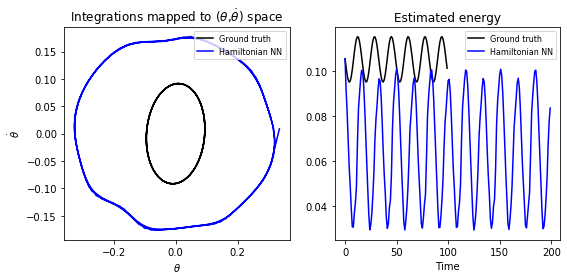

In [0]:
# plot trajectories in cc-space
fig = plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title('Integrations mapped to ($\\theta$,$\dot \\theta$) space'.format('pixels'))
plt.xlabel("$\\theta$") ; plt.ylabel("$\dot \\theta$")

plt.plot(data['coords'][:100][:,0], data['coords'][:100][:,1], 'k-', label='Ground truth')
plt.plot(hnn_cc[:100][:,0], hnn_cc[:100][:,1], 'b-', label='Hamiltonian NN')
# plt.plot(base_cc[:100][:,0], base_cc[:100][:,1], 'r-', label='Baseline NN')

# plt.xlim(-.5,.5) ; plt.ylim(-1.5,2.3)
plt.legend(fontsize=8, loc='upper right')

# plot estimated energy
plt.subplot(1,2,2)
plt.title('Estimated energy') ; plt.xlabel('Time')
plt.plot(true_e[:100], 'k', label='Ground truth')
plt.plot(hnn_e, 'b', label='Hamiltonian NN')
# plt.plot(base_e, 'r', label='Baseline NN')
plt.legend(fontsize=8)

plt.tight_layout() ; plt.show()

In [0]:
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)

def np_L2_dist(x, xhat):
    return (x-xhat)**2

base_distance = np_L2_dist(true_e[:100], base_e[:100])
hnn_distance = np_L2_dist(true_e[:100], hnn_e[:100])

splits = 5
print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(base_distance), bootstrap_conf(base_distance, splits),
          np.mean(hnn_distance), bootstrap_conf(hnn_distance, splits))
     )


Baseline NN energy MSE: 1.6498e-01 +/- 4.78e-02
Hamiltonian NN energy MSE: 2.3617e-03 +/- 1.74e-04
